In [1]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [2]:
!pip install transformers sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
path = '/drive/MyDrive/ml/dl_course_2022/tripadvisor_hotel_reviews.csv'

In [4]:
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tokenizers import ByteLevelBPETokenizer
from tokenizers.pre_tokenizers import Whitespace
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [5]:
data = pd.read_csv(path)

In [6]:
train, test = train_test_split(data, test_size=0.2)

In [7]:
tokenizer = ByteLevelBPETokenizer()
tokenizer.pre_tokenizer = Whitespace()

tokenizer.enable_padding(pad_id=0, pad_token='<pad>')

In [8]:
texts = [text.lower() for text in list(train['Review'])]

In [9]:
with open('texts.txt', 'w') as f:
    for text in texts:
        f.write("%s\n" % text)

In [10]:
tokenizer.train(
    files=['/content/texts.txt'],
    vocab_size=3_000,
    min_frequency=2,
    special_tokens=['<pad>', '<unk>']
    )

In [11]:
tokenizer.save('/content/tokenizer.json')

In [12]:
tokens_list = [tokenizer.encode(text).ids for text in texts]

In [13]:
train['tokens'] = tokens_list

In [14]:
len_list = [len(tokens) for tokens in list(train['tokens'])]

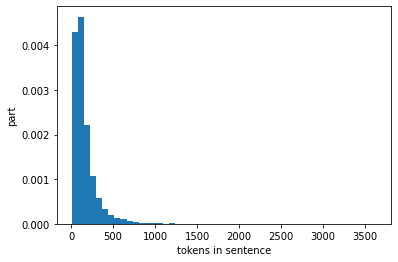

In [15]:
plt.hist(len_list, density=True, bins=50)
plt.ylabel('part')
plt.xlabel('tokens in sentence');

In [16]:
max_len = 128

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):

    def __init__(self, tokens, labels, max_len):
        self.tokens = tokens
        self.labels = labels

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        label = self.labels[idx]
        label = torch.tensor(label)
        tokens = self.tokens[idx]
        out = torch.zeros(max_len, dtype=torch.long)
        out[:len(tokens)] = torch.tensor(tokens, dtype=torch.long)[:max_len]
        return out, label

In [18]:
train_texts = [text.lower() for text in list(train['Review'])]
train_ids = [tokenizer.encode(text).ids for text in train_texts]
train_labels = [ i - 1 for i in list(train['Rating'])]
train_dataset = CustomDataset(train_ids, train_labels, max_len)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=False)

In [19]:
test_texts = [text.lower() for text in list(test['Review'])]
test_ids = [tokenizer.encode(text).ids for text in test_texts]
test_labels = [ i - 1 for i in list(test['Rating'])]
test_dataset = CustomDataset(test_ids, test_labels, max_len)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
class NeuralNetwork(nn.Module):


    def __init__(self, hidden_dim=128, vocab_size=3000, embedding_dim=128, linear_dim=128, dropout=0.1, n_classes=5):
        super(NeuralNetwork, self).__init__()
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_layer = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout_layer = nn.Dropout(dropout)        
        self.fc_layer = nn.Linear(hidden_dim * 2, linear_dim)
        self.batchnorm = nn.BatchNorm1d(linear_dim)
        self.relu = nn.ReLU()
        self.out_layer = nn.Linear(linear_dim, n_classes)


    def forward(self, inputs):
        batch_size = inputs.size(0)
        embeddings = self.embedding_layer(inputs)
        lstm_out, (ht, ct) = self.lstm_layer(embeddings)
        out = ht.transpose(0, 1)
        out = out.reshape(batch_size, -1)
        out = self.fc_layer(out)
        out = self.batchnorm(out)
        out = self.relu(out)
        out = self.dropout_layer(out)
        out = self.out_layer(out)
        out = torch.squeeze(out, 1)
        out = torch.sigmoid(out)
        return out

In [22]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [23]:
def eval_nn(model, data_loader):
    predicted = []
    labels = []
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            x, y = data
            x = x.to(device)
            outputs = model(x)
            _, predict = torch.max(outputs.data, 1)
            predict = predict.cpu().detach().numpy().tolist()
            predicted += predict
            labels += y
        score = f1_score(labels, predicted, average='macro')
    return labels, predicted, score

In [24]:
def train_nn(model, optimizer, loss_function, train_loader, test_loader, device, epochs=50):
    best_score = 0
    for epoch in range(epochs):
        model.train()
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            predict = model(inputs)
            loss = loss_function(predict, labels)
            loss.backward()
            optimizer.step()
        _, _, score = eval_nn(model, test_loader)
        print(score)
        if score > best_score:
            torch.save(model,'/content/model_best_test_' + str(round(score, 4)) + '.pt')
            best_score = score
    return best_score

In [25]:
loss_function = nn.CrossEntropyLoss().to(device)
model = NeuralNetwork()
model.apply(init_weights)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr = 0.01)

In [ ]:
train_nn(model, optimizer, loss_function, train_loader, test_loader, device)

100%|██████████| 8196/8196 [01:16<00:00, 106.48it/s]


0.121724372029871


100%|██████████| 8196/8196 [01:11<00:00, 114.88it/s]


0.121724372029871


100%|██████████| 8196/8196 [01:12<00:00, 113.71it/s]


0.121724372029871


100%|██████████| 8196/8196 [01:11<00:00, 114.82it/s]


0.13254269565421328


100%|██████████| 8196/8196 [01:11<00:00, 115.23it/s]


0.121724372029871


100%|██████████| 8196/8196 [01:26<00:00, 95.30it/s] 


0.19268220265838082


100%|██████████| 8196/8196 [01:11<00:00, 115.27it/s]


0.19916082320695827


100%|██████████| 8196/8196 [01:12<00:00, 113.13it/s]


0.19984918987160194


100%|██████████| 8196/8196 [01:11<00:00, 113.96it/s]


0.21748147039005766


100%|██████████| 8196/8196 [01:10<00:00, 115.68it/s]


0.21143142215208507


100%|██████████| 8196/8196 [01:11<00:00, 114.55it/s]


0.2119488233498247


100%|██████████| 8196/8196 [01:11<00:00, 114.42it/s]


0.21583251352680763


100%|██████████| 8196/8196 [01:11<00:00, 113.89it/s]


0.21714517234437375


100%|██████████| 8196/8196 [01:12<00:00, 113.67it/s]


0.21414311510052136


 94%|█████████▍| 7736/8196 [01:07<00:04, 112.89it/s]